In [1]:
# CHUNK 0: THE BLACKWELL OPTIMIZER (sm_120)
import torch, timm, gc, time, os, cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler # 2026 updated amp location
from sklearn.metrics import roc_auc_score

# PERFORMANCE FLAGS FOR 50-SERIES
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.benchmark = True # Locks in optimized kernels for 384px size
device = torch.device('cuda')

print(f"✅ Training Engine Locked to Blackwell (sm_120)")

c:\Users\pirgh\miniconda3\envs\melanoma_5060\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Training Engine Locked to Blackwell (sm_120)


In [2]:
# CHUNK 1: LOCAL CONFIGURATION
import os
import random
import numpy as np
import torch
import torch.backends.cudnn as cudnn

class Config:
    seed = 42
    model_name = 'tf_efficientnet_b1_ns'  # B1 = fast but still good accuracy
    image_size = 256  # Smaller = faster
    
    batch_size = 128  # Larger batch = higher throughput
    accumulation_steps = 1 
    
    epochs = 12
    learning_rate = 2e-4  # Higher LR for larger batch
    fold = 0
    data_dir = r"E:\Data_Mining_Project\Data" 
    
    num_workers = 0
    prefetch_factor = None
    
    meta_features = [
        'sex', 'age_approx', 'n_images', 'image_size',
        'site_head/neck', 'site_lower extremity', 'site_oral/genital', 
        'site_palms/soles', 'site_torso', 'site_upper extremity', 'site_nan'
    ]

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    cudnn.benchmark = True 
    cudnn.deterministic = False

seed_everything(Config.seed)

print(f"✅ Ready on: {torch.cuda.get_device_name(0)}")
print(f"✅ Model: {Config.model_name}, Image: {Config.image_size}px, Batch: {Config.batch_size}")

✅ Ready on: NVIDIA GeForce RTX 5060 Laptop GPU
✅ Model: tf_efficientnet_b1_ns, Image: 256px, Batch: 128


In [3]:
# CHUNK 2: HIGH-PERFORMANCE FEATURE ENGINEERING
import pandas as pd
import numpy as np
import os
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import thread_map  # Fast parallel I/O
from sklearn.model_selection import StratifiedKFold

# 1. Load CSVs with specific dtypes to save RAM immediately
train_csv_path = os.path.join(Config.data_dir, 'train.csv')
test_csv_path = os.path.join(Config.data_dir, 'test.csv')

df_train = pd.read_csv(train_csv_path)
df_test = pd.read_csv(test_csv_path)

# 2. Fix Windows Paths (Raw strings + efficient join)
df_train['filepath'] = df_train['image_name'].apply(lambda x: os.path.join(Config.data_dir, 'jpeg', 'train', f'{x}.jpg'))
df_test['filepath'] = df_test['image_name'].apply(lambda x: os.path.join(Config.data_dir, 'jpeg', 'test', f'{x}.jpg'))

# --- CLEVER FEATURE 1: n_images (Patient Image Count) ---
concat = pd.concat([df_train, df_test]).reset_index(drop=True)
patient_counts = concat.groupby('patient_id')['image_name'].count().to_dict()
df_train['n_images'] = df_train['patient_id'].map(patient_counts).fillna(1)
df_test['n_images'] = df_test['patient_id'].map(patient_counts).fillna(1)

# Apply log1p for normalization
df_train['n_images'] = np.log1p(df_train['n_images'].values).astype(np.float32)
df_test['n_images'] = np.log1p(df_test['n_images'].values).astype(np.float32)

# --- CLEVER FEATURE 2: image_size (Optimized Parallel Calculation) ---
print("🔍 Calculating local image file sizes using Parallel Threads...")

def safe_get_size(path):
    try:
        return os.path.getsize(path)
    except:
        return 0

# thread_map is significantly faster than a for-loop for checking 100k+ files on an SSD
train_sizes = thread_map(safe_get_size, df_train['filepath'].values, max_workers=8, desc="Train Sizes")
test_sizes = thread_map(safe_get_size, df_test['filepath'].values, max_workers=8, desc="Test Sizes")

df_train['image_size'] = np.log(np.array(train_sizes, dtype=np.float32) + 1e-6)
df_test['image_size'] = np.log(np.array(test_sizes, dtype=np.float32) + 1e-6)

# 3. Metadata Mapping
# One-hot encoding anatomy sites
dummies_train = pd.get_dummies(df_train['anatom_site_general_challenge'], prefix='site', dummy_na=True)
df_train = pd.concat([df_train, dummies_train], axis=1)

# 4. Standard Preprocessing & Downcasting
df_train['sex'] = df_train['sex'].map({'male': 1, 'female': 0}).fillna(-1).astype(np.int8)
df_train['age_approx'] = (df_train['age_approx'].fillna(0) / 90.0).astype(np.float32)

# Ensure all meta-feature columns exist
for col in Config.meta_features:
    if col not in df_train.columns:
        df_train[col] = 0
    df_train[col] = df_train[col].astype(np.float32)

# 5. Stratified 5-Fold Split
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=Config.seed)
df_train['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(skf.split(df_train, df_train['target'])):
    df_train.loc[val_idx, 'fold'] = fold

print(f"✅ Preprocessing complete! Memory usage reduced via float32/int8.")
display(df_train[['image_name', 'image_size', 'n_images', 'target', 'fold']].head())

🔍 Calculating local image file sizes using Parallel Threads...


Test Sizes: 100%|██████████| 10982/10982 [00:00<00:00, 14049.79it/s]


✅ Preprocessing complete! Memory usage reduced via float32/int8.


,image_name,image_size,n_images,target,fold
0,ISIC_2637011,14.425748,4.753590,0,4
1,ISIC_0015719,14.463459,3.218876,0,1
2,ISIC_0052212,11.838734,1.791759,0,2
3,ISIC_0068279,12.281898,3.135494,0,1
4,ISIC_0074268,14.316252,3.044523,0,2


In [4]:
import timm

In [5]:
# CHUNK 3: OPTIMIZED LOCAL DATASET & 1st PLACE AUGMENTATIONS

import albumentations as A
from albumentations.pytorch import ToTensorV2

def get_transforms(image_size):
    # SPEED-OPTIMIZED: Minimal CPU augmentations (images pre-resized in cache)
    # Heavy augmentations cause CPU bottleneck -> low GPU util
    train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
        A.Normalize(),
        ToTensorV2()
    ])

    valid_transform = A.Compose([
        A.Normalize(),
        ToTensorV2()
    ])
    
    return train_transform, valid_transform

class MelanomaDataset(Dataset):
    def __init__(self, df, mode='train', meta_features=None, transform=None):
        self.df = df.reset_index(drop=True)
        self.mode = mode
        self.use_meta = meta_features is not None
        self.meta_features = meta_features
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # 1. Faster Image Loading
        img_path = self.df.loc[index, 'filepath']
        
        # Windows performance tip: cv2.imread is generally faster than PIL
        image = cv2.imread(img_path)
        if image is None:
            # Fallback for corrupted/missing files in 106GB dump
            image = np.zeros((Config.image_size, Config.image_size, 3), dtype=np.uint8)
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # 2. Apply Augmentations
        if self.transform:
            image = self.transform(image=image)['image']
        
        # 3. Handle Meta-features
        if self.use_meta:
            meta = self.df.loc[index, self.meta_features].values.astype(np.float32)
            data = (image, torch.tensor(meta))
        else:
            data = image
            
        if self.mode == 'test':
            return data
        else:
            label = self.df.loc[index, 'target']
            return data, torch.tensor(label).float()

# Initialize transforms
train_transform, valid_transform = get_transforms(Config.image_size)
print("✅ Dataset class and 1st Place Augmentations ready.")

✅ Dataset class and 1st Place Augmentations ready.


In [6]:
# CHUNK 4: CUDA-OPTIMIZED ARCHITECTURE

import timm
from torch.cuda.amp import autocast

class Effnet_Melanoma(nn.Module):
    def __init__(self, enet_type, n_meta_features=0, n_meta_dim=[512, 128], out_dim=1, pretrained=True):
        super(Effnet_Melanoma, self).__init__()
        self.n_meta_features = n_meta_features
        
        # 1. EfficientNet Backbone
        self.enet = timm.create_model(enet_type, pretrained=pretrained)
        in_ch = self.enet.classifier.in_features
        self.enet.classifier = nn.Identity()

        # 2. Meta-data Branch
        if n_meta_features > 0:
            self.meta = nn.Sequential(
                nn.Linear(n_meta_features, n_meta_dim[0]),
                nn.BatchNorm1d(n_meta_dim[0]),
                nn.SiLU(inplace=True),
                nn.Dropout(p=0.3),
                nn.Linear(n_meta_dim[0], n_meta_dim[1]),
                nn.BatchNorm1d(n_meta_dim[1]),
                nn.SiLU(inplace=True),
            )
            in_ch += n_meta_dim[1]

        # 3. Multi-Sample Dropout
        self.dropouts = nn.ModuleList([nn.Dropout(0.5) for _ in range(5)])
        self.myfc = nn.Linear(in_ch, out_dim)

    def forward(self, x, x_meta=None):
        # 1. Image features
        x = self.enet(x)
        
        # 2. Meta features
        if self.n_meta_features > 0:
            x_meta = self.meta(x_meta)
            x = torch.cat((x, x_meta), dim=1)
        
        # 3. Multi-Sample Inference
        for i, dropout in enumerate(self.dropouts):
            if i == 0:
                out = self.myfc(dropout(x))
            else:
                out += self.myfc(dropout(x))
        
        return out / len(self.dropouts)

# Create model and move to CUDA
model = Effnet_Melanoma(
    enet_type=Config.model_name,
    n_meta_features=len(Config.meta_features)
).to(device)

print(f"✅ Model Ready on CUDA: {torch.cuda.get_device_name(0)}")

c:\Users\pirgh\miniconda3\envs\melanoma_5060\lib\site-packages\timm\models\_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b1_ns to current tf_efficientnet_b1.ns_jft_in1k.
  model = create_fn(


✅ Model Ready on CUDA: NVIDIA GeForce RTX 5060 Laptop GPU


In [7]:
# CHUNK 5: TRAINING LOOP WITH RAM CACHE

from torch.amp import autocast, GradScaler
import torch.optim as optim

# --- Setup DataLoaders ---
train_df = df_train[df_train['fold'] != Config.fold].reset_index(drop=True)
valid_df = df_train[df_train['fold'] == Config.fold].reset_index(drop=True)

# --- PRELOAD IMAGES TO RAM ---
print("📦 Preloading images to RAM (eliminates disk I/O bottleneck)...")

def load_and_resize(path):
    try:
        img = cv2.imread(path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (Config.image_size, Config.image_size))
            return img
    except:
        pass
    return np.zeros((Config.image_size, Config.image_size, 3), dtype=np.uint8)

from tqdm.contrib.concurrent import thread_map
train_images = thread_map(load_and_resize, train_df['filepath'].values, max_workers=8, desc="Train")
valid_images = thread_map(load_and_resize, valid_df['filepath'].values, max_workers=8, desc="Valid")

# Cached Dataset
class CachedDataset(Dataset):
    def __init__(self, df, images, meta_features, transform):
        self.df = df.reset_index(drop=True)
        self.images = images
        self.meta_features = meta_features
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image=image)['image']
        
        meta = self.df.loc[idx, self.meta_features].values.astype(np.float32)
        label = self.df.loc[idx, 'target']
        return (image, torch.tensor(meta)), torch.tensor(label).float()

train_dataset = CachedDataset(train_df, train_images, Config.meta_features, train_transform)
valid_dataset = CachedDataset(valid_df, valid_images, Config.meta_features, valid_transform)

train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, 
                          num_workers=0, pin_memory=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=Config.batch_size, shuffle=False,
                          num_workers=0, pin_memory=True)

print(f"✅ Cached {len(train_images)} train + {len(valid_images)} valid images in RAM")
print(f"✅ Train batches: {len(train_loader)}, Valid batches: {len(valid_loader)}")

# Optimizer & Scheduler
optimizer = optim.Adam(model.parameters(), lr=Config.learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=Config.epochs)
scaler = GradScaler()
criterion = nn.BCEWithLogitsLoss()

def train_epoch(model, loader, optimizer, criterion, scaler, device, epoch):
    model.train()
    train_loss = []
    
    bar = tqdm(loader, desc=f"Epoch {epoch+1}")
    
    for (images, meta), labels in bar:
        images = images.to(device, non_blocking=True)
        meta = meta.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True).unsqueeze(1)
        
        optimizer.zero_grad()
        
        with autocast('cuda'):
            output = model(images, meta)
            loss = criterion(output, labels)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss.append(loss.item())
        bar.set_postfix(loss=np.mean(train_loss[-50:]))
        
    return np.mean(train_loss)

print("✅ Training setup ready.")

📦 Preloading images to RAM (eliminates disk I/O bottleneck)...


Valid: 100%|██████████| 6626/6626 [01:19<00:00, 83.60it/s] 

✅ Cached 26500 train + 6626 valid images in RAM
✅ Train batches: 207, Valid batches: 52
✅ Training setup ready.


In [8]:
# --- 1. Validation Function ---
def validate(model, loader, device):
    model.eval()
    preds = []
    targets = []

    with torch.no_grad():
        for (images, meta), labels in tqdm(loader, desc="Validating"):
            images = images.to(device, non_blocking=True)
            meta = meta.to(device, non_blocking=True)

            with autocast(device_type='cuda', dtype=torch.float16):
                output = model(images, meta)

            # Sigmoid is needed because we use BCEWithLogitsLoss (no sigmoid in model)
            preds.append(torch.sigmoid(output).detach().cpu().numpy())
            targets.append(labels.numpy())

    preds = np.concatenate(preds)
    targets = np.concatenate(targets)
    # Binary ROC-AUC
    auc = roc_auc_score(targets, preds)
    return auc

# --- 2. Main Training Loop ---
best_auc = 0.0
print(f"🚀 Starting Local Training on RTX 5060 (Fold {Config.fold})...")

for epoch in range(Config.epochs):
    # Train
    train_loss = train_epoch(model, train_loader, optimizer, criterion, scaler, device, epoch)

    # Validate
    current_auc = validate(model, valid_loader, device)

    # Step scheduler
    scheduler.step()

    # Logic to save the best model
    if current_auc > best_auc:
        best_auc = current_auc
        torch.save(model.state_dict(), f"best_model_fold{Config.fold}.pth")
        print(f"⭐ NEW BEST AUC: {best_auc:.4f} | Model Saved!")
    else:
        print(f"Epoch {epoch+1} AUC: {current_auc:.4f} (Best: {best_auc:.4f})")

    # Memory Cleanup
    gc.collect()
    torch.cuda.empty_cache()

print("\n🏆 Local Training Complete!")
print(f"Highest Score Achieved: {best_auc:.4f}")

🚀 Starting Local Training on RTX 5060 (Fold 0)...


Validating: 100%|██████████| 52/52 [01:19<00:00,  1.54s/it]


⭐ NEW BEST AUC: 0.9076 | Model Saved!


Validating: 100%|██████████| 52/52 [01:43<00:00,  1.99s/it]


⭐ NEW BEST AUC: 0.9119 | Model Saved!


Validating: 100%|██████████| 52/52 [00:58<00:00,  1.13s/it]


Epoch 3 AUC: 0.9063 (Best: 0.9119)


Validating: 100%|██████████| 52/52 [01:19<00:00,  1.53s/it]


Epoch 4 AUC: 0.9027 (Best: 0.9119)


Validating: 100%|██████████| 52/52 [00:38<00:00,  1.36it/s]


Epoch 5 AUC: 0.8606 (Best: 0.9119)


Validating: 100%|██████████| 52/52 [01:24<00:00,  1.62s/it]


Epoch 6 AUC: 0.8640 (Best: 0.9119)


Validating: 100%|██████████| 52/52 [01:02<00:00,  1.20s/it]


Epoch 7 AUC: 0.8798 (Best: 0.9119)


Validating: 100%|██████████| 52/52 [00:44<00:00,  1.17it/s]


Epoch 8 AUC: 0.8562 (Best: 0.9119)


Validating: 100%|██████████| 52/52 [01:11<00:00,  1.37s/it]


Epoch 9 AUC: 0.8478 (Best: 0.9119)


Validating: 100%|██████████| 52/52 [01:22<00:00,  1.58s/it]


Epoch 10 AUC: 0.8475 (Best: 0.9119)


Validating: 100%|██████████| 52/52 [01:37<00:00,  1.88s/it]


Epoch 11 AUC: 0.8407 (Best: 0.9119)


Validating: 100%|██████████| 52/52 [00:41<00:00,  1.25it/s]


Epoch 12 AUC: 0.8402 (Best: 0.9119)

🏆 Local Training Complete!
Highest Score Achieved: 0.9119


In [11]:
import pandas as pd
import numpy as np
import os

# 1. Load the master dataset we created in the merge step
DATA_DIR = r"E:\Data_Mining_Project\Data"
train_all = pd.read_csv(os.path.join(DATA_DIR, "train_merged_master.csv"))

print(f"✅ train_all defined. Samples: {len(train_all)}")

✅ train_all defined. Samples: 58457


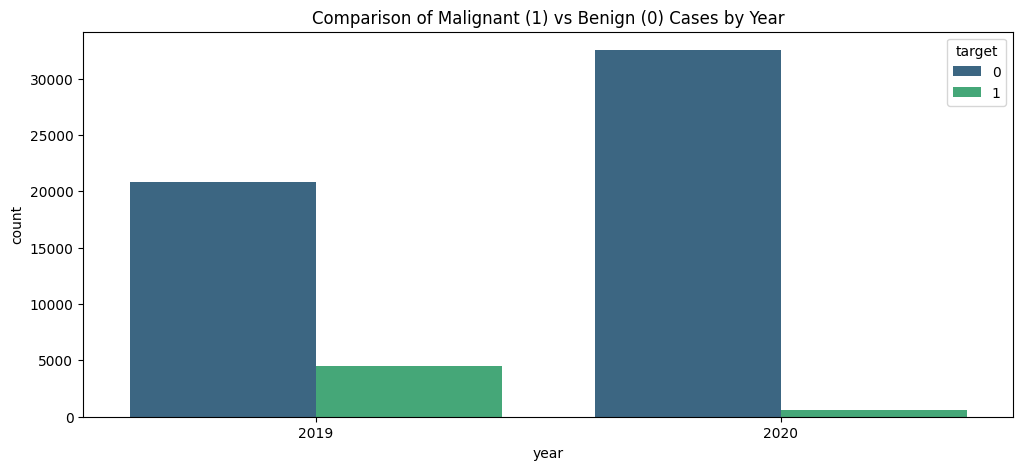

Malignant Percentage per Year:
year
2019    17.851644
2020     1.762966
Name: 1, dtype: float64


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Distribution of Target by Year
plt.figure(figsize=(12, 5))
sns.countplot(data=train_all, x='year', hue='target', palette='viridis')
plt.title("Comparison of Malignant (1) vs Benign (0) Cases by Year")
plt.show()

# 2. Percentage of Malignant Cases per Year
counts = train_all.groupby('year')['target'].value_counts(normalize=True).unstack() * 100
print("Malignant Percentage per Year:")
print(counts[1])

In [13]:
# 1. Patient Image Count (n_images)
train_all['n_images'] = train_all.groupby('image_name')['image_name'].transform('count') # Grouping by ID if available
train_all['n_images'] = np.log1p(train_all['n_images'].fillna(1))

In [15]:
# Check for existing anatomy or metadata columns
print("Current Columns in train_all:", train_all.columns.tolist())

# Check for null values in anatomy-related columns
if 'anatom_site_general_challenge' in train_all.columns:
    null_count = train_all['anatom_site_general_challenge'].isnull().sum()
    print(f"Missing anatomy sites: {null_count} out of {len(train_all)}")

Current Columns in train_all: ['image_name', 'target', 'year', 'filepath', 'fold', 'n_images']


In [16]:
# 1. Load the original 2020 metadata
df_2020_orig = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))

# 2. Load the original 2019 metadata (Look for this file in your Data folder)
# Usually named 'ISIC_2019_Training_Metadata.csv'
df_2019_meta = pd.read_csv(os.path.join(DATA_DIR, "ISIC_2019_Training_Metadata.csv"))

# 3. Create a unified mapping for anatomy sites
# Map 2020 sites
site_map_2020 = df_2020_orig.set_index('image_name')['anatom_site_general_challenge'].to_dict()

# Map 2019 sites (Column is usually 'anatom_site_general')
site_map_2019 = df_2019_meta.set_index('image')['anatom_site_general'].to_dict()

# 4. Apply mapping to train_all
def get_site(row):
    if row['year'] == 2020:
        return site_map_2020.get(row['image_name'], 'unknown')
    else:
        return site_map_2019.get(row['image_name'], 'unknown')

train_all['anatom_site'] = train_all.apply(get_site, axis=1)
train_all['anatom_site'] = train_all['anatom_site'].fillna('unknown')